In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os 
from scipy.optimize import curve_fit

plt.rcParams.update({
    "font.family": "STIXGeneral",  # A LaTeX-like serif font
    "mathtext.fontset": "stix",  # For math symbols
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


In [20]:
fil = '251'
data = np.load(f"./Data_Run_{fil}.npz")

print(data)
#for x in data.items() : 
#    print(x)

NpzFile './Data_Run_251.npz' with keys: motor_positions, widths_X, widths_Y, fit_centroid_X, fit_centroid_Y...


In [21]:
def gaussian(pos, A, sig, mu, D) : 
    return A * np.exp(-(pos-mu)**2/(2*sig**2)) + D
# to get actual width multiply sig by 4

def get_guess(data_i, data_pos) : 
    return [max(data_i), 1, np.mean(data_pos), np.mean(data_i)]

def fit_gaussian(data_I, data_pos):
    widths, err_widths = [], []
    mus, err_mus = [], []

    for i, (intensities, positions) in enumerate(zip(data_I, data_pos)):
        p0 = get_guess(intensities, positions)
        
        if i > 0:
            p0[1] = widths[-1] / 4
            p0[2] = mus[-1]

        popt, pcov = curve_fit(gaussian, positions, intensities, p0=p0)
        errs = np.sqrt(np.diag(pcov)) 

        widths.append(4 * popt[1])
        mus.append(popt[2])
        err_widths.append(4 * errs[1])
        err_mus.append(errs[2])

    return np.array(widths), np.array(err_widths), np.array(mus), np.array(err_mus)

widths_x, err_widths_x, mus_x, err_mus_x = fit_gaussian(data['data_X_I'], data['data_X_pos'])
widths_y, err_widths_y, mus_y, err_mus_y = fit_gaussian(data['data_Y_I'], data['data_Y_pos'])


In [22]:
print(err_widths_y)

[1.2407795  1.05084169 1.11903023 0.95128311 0.90554926 0.70847532
 0.77528538 0.54485099 0.76914914 0.59621185 0.65827146 0.63592189
 0.78316456 0.85068277 0.74053849 0.82087006]


In [23]:
def m_func(z, *ps) : 
    w0, M, z0 = ps[0], ps[1], ps[2]

    lambd = 410*1e-3 # m
    return w0 * np.sqrt(1 + (M*1000 * (lambd * (z-z0))/(np.pi*w0**2) )**2 )

mot_zs = data['motor_positions']
init_guess = [30, 3, 185]
popt_x, pcov_x = curve_fit(m_func, mot_zs, widths_x, p0=init_guess, absolute_sigma=False)#, sigma=err_widths_x)
popt_y, pcov_y = curve_fit(m_func, mot_zs, widths_y, p0=init_guess, absolute_sigma=False)#, sigma=err_widths_y)

print(popt_x)
print(popt_y)

errs_x = np.sqrt(np.diag(pcov_x))
errs_y = np.sqrt(np.diag(pcov_y))
print(errs_x)
print(errs_y)

[343.2220687    8.55560468 204.01530952]
[364.52168802   9.12619802 207.89477922]
[4.27221265 0.12438597 2.00830589]
[3.04618261 0.09933967 1.56302648]


<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_26281/2088155923.py:15: SyntaxWarning: invalid escape sequence '\m'
  fmt='s', color='k', markerfacecolor='tab:blue', markeredgewidth=1.0, label=f'Horisontal: $\mathrm{{M}}$ = {popt_x[1]:.1f}({1}) $\mathrm{{mm}}$',
/tmp/ipykernel_26281/2088155923.py:15: SyntaxWarning: invalid escape sequence '\m'
  fmt='s', color='k', markerfacecolor='tab:blue', markeredgewidth=1.0, label=f'Horisontal: $\mathrm{{M}}$ = {popt_x[1]:.1f}({1}) $\mathrm{{mm}}$',
/tmp/ipykernel_26281/2088155923.py:18: SyntaxWarning: invalid escape sequence '\m'
  fmt='D', color='k', markerfacecolor='tab:red', 

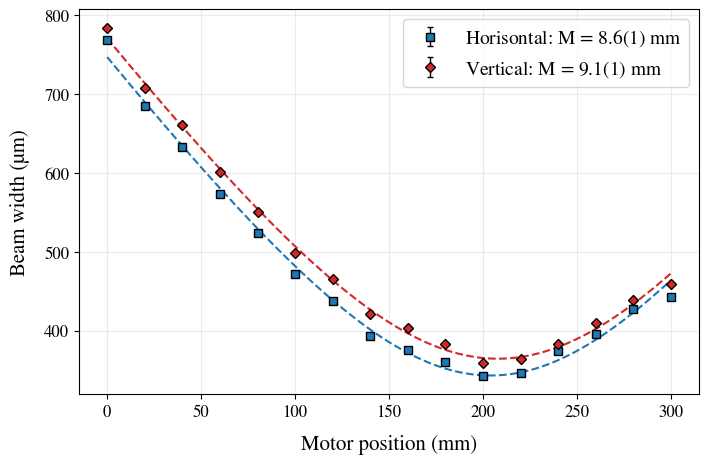

In [25]:
fig, ax = plt.subplots(figsize=(8,5))


zslin = np.linspace(min(mot_zs), max(mot_zs), 10000)
wfit_x = m_func(zslin, *popt_x)
wfit_y = m_func(zslin, *popt_y)

ax.plot(zslin, wfit_x, '--', color='tab:blue')
ax.plot(zslin, wfit_y, '--', color='tab:red')

#ax.plot(zslin, -wfit_x/2, '--', color='tab:blue', alpha=1.0)
#ax.plot(zslin, -wfit_y/2, '--', color='tab:red', alpha=1.0)

ax.errorbar(mot_zs, widths_x, yerr=err_widths_x, markersize=5.5, 
            fmt='s', color='k', markerfacecolor='tab:blue', markeredgewidth=1.0, label=f'Horisontal: $\mathrm{{M}}$ = {popt_x[1]:.1f}({1}) $\mathrm{{mm}}$', 
            linewidth=0.85, elinewidth=1.0, capsize=2.0, ecolor='k')
ax.errorbar(mot_zs, widths_y, yerr=err_widths_y, markersize=5.5, 
            fmt='D', color='k', markerfacecolor='tab:red', markeredgewidth=1.0, label=f'Vertical: $\mathrm{{M}}$ = {popt_y[1]:.1f}({1}) $\mathrm{{mm}}$',
            linewidth=0.85, elinewidth=1.0, capsize=2.0, ecolor='k')

ax.grid(alpha=0.25)

ax.set_xlabel("Motor position (mm)", fontsize=15, labelpad=10)
ax.set_ylabel("Beam width (µm)", fontsize=15, labelpad=10)

ax.legend(fontsize=14)

# MINI PLOT
if(False) : 
    ax_inset = ax.inset_axes([0.47, 0.4, 0.35, 0.35])  # (x0, y0, width, height)
    mark_inset(ax, ax_inset, loc1=3, loc2=4, ec="0.2", linestyle="--")

    ax_inset.plot(zslin, wfit_x, '--', color='tab:blue')
    ax_inset.plot(zslin, wfit_y, '--', color='tab:red')

    ax_inset.errorbar(mot_zs, widths_x, yerr=err_widths_x, markersize=3.5, 
                    fmt='s', color='k', markerfacecolor='tab:blue', markeredgewidth=0.75, linewidth=0.5)
    ax_inset.errorbar(mot_zs, widths_y, yerr=err_widths_y, markersize=3.5, 
                    fmt='D', color='k', markerfacecolor='tab:red', markeredgewidth=0.75, linewidth=0.5)

    ax_inset.set_xlim(175, 205)
    ax_inset.set_ylim(-50, 300)

    ax_inset.grid(alpha=0.3)


# beam not fully collimated

fig.savefig(f"beam-profile-{fil}.png", format='png', bbox_inches="tight", dpi=300)

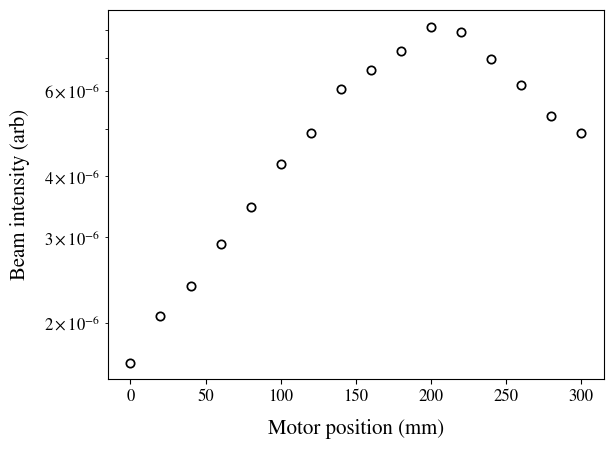

In [271]:
fig, ax = plt.subplots()

pos = data['motor_positions']
xwdith = data['widths_X']
ywdith = data['widths_Y']

ax.plot(pos, 1/(widths_x*widths_y), 'ko', markerfacecolor='w', markeredgewidth=1.25)
ax.set_yscale('log')

ax.set_ylabel("Beam intensity (arb)", fontsize=15, labelpad=10)
ax.set_xlabel("Motor position (mm)", fontsize=15, labelpad=10)

fig.savefig(f"beam-intensity-{fil}.png", format='png', bbox_inches="tight", dpi=300)

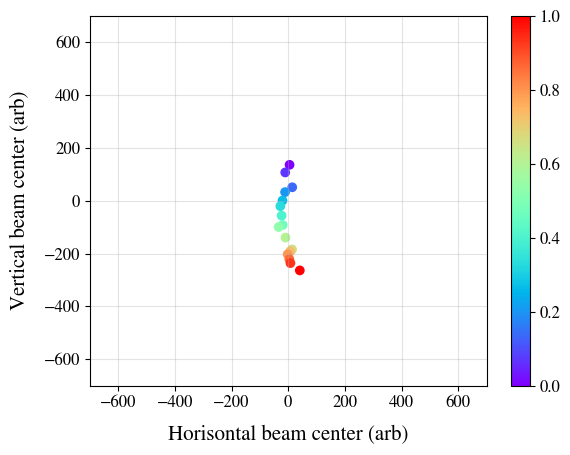

In [272]:
fig, ax = plt.subplots()

colors = np.linspace(0, 1, len(mus_x))  
cmap = plt.get_cmap('rainbow') 

sc = ax.scatter(mus_x, mus_y, c=colors, cmap=cmap)
plt.colorbar(sc)

ax.set_xlim(-700, 700)
ax.set_ylim(-700, 700)

ax.set_ylabel("Vertical beam center (arb)", fontsize=15, labelpad=10)
ax.set_xlabel("Horisontal beam center (arb)", fontsize=15, labelpad=10)

ax.grid(alpha=0.35)

fig.savefig(f"beam-walk-{fil}.png", format='png', bbox_inches="tight", dpi=300)


#ax.plot(mus_x, mus_y, 'o')

In [247]:
run = "74"
path = f"./Run_{run}/"
files = os.listdir(path)

signal_pd = []
signal_pmt = []
positions = []

for file in files : 

    data2 = np.load(path+file, allow_pickle=True)
    # _ number_of_digitzer (0: pmt, 1 photodiode), timestamp, lang gate (brug), kort gate (brug ikke)

    #print(data2)

    pos = data2['motor_position']
    pick = data2['raw_data'][:,1]

    pmt_data = data2['raw_data'][pick == 0]
    pd_data = data2['raw_data'][pick == 1]

    positions.append(pos)
    signal_pd.append( np.mean(pd_data[:,3]) )
    signal_pmt.append( np.mean(pmt_data[:,3]) )


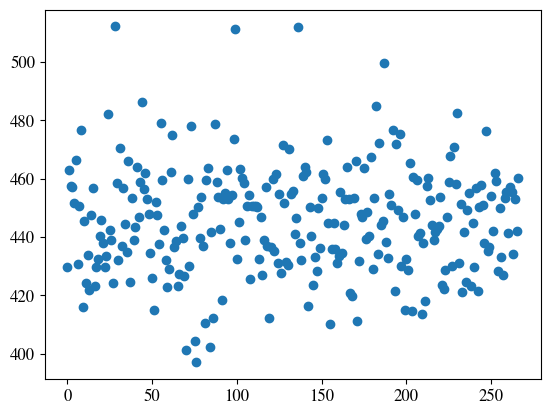

In [248]:
fig, ax = plt.subplots()

ax.plot(np.arange(0,len(signal_pd)), signal_pd, 'o')

182
184.39999999999975


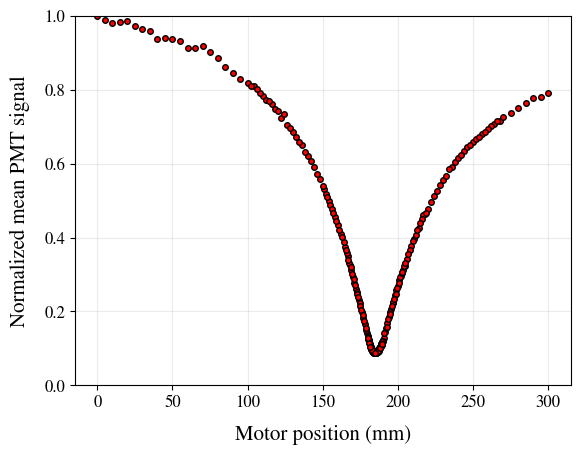

In [249]:
fig, ax = plt.subplots()

new_popt_x = popt_x
new_popt_x[2] = 187.4

new_popt_y = popt_y
new_popt_y[2] = 187.4

peak_fluence = 1/(m_func(positions, *new_popt_x)*m_func(positions, *new_popt_y))

ax.plot(positions, signal_pmt/max(signal_pmt), 'o', markeredgecolor='k', markerfacecolor='r', markersize=4)
ax.set_ylim(0.0, 1.0)

print(np.argmin(signal_pmt))
print(positions[182])
#ax.set_xscale('log')

ax.set_xlabel("Motor position (mm)", fontsize=15, labelpad=10)
ax.set_ylabel("Normalized mean PMT signal", fontsize=15, labelpad=10)
ax.grid(alpha=0.25)

# MINI PLOT
#ax_inset = ax.inset_axes([0.1, 0.2, 0.35, 0.35])  # (x0, y0, width, height)
#mark_inset(ax, ax_inset, loc1=3, loc2=4, ec="0.2", linestyle="--")

#ax_inset.plot(positions, signal_pmt/max(signal_pmt), 'o', markeredgecolor='k', markerfacecolor='r', markersize=4)

#ax_inset.set_xlim(175, 200)
#ax_inset.set_ylim(0.0, 0.3)
#ax_inset.grid(alpha=0.3)

fig.savefig(f"pmt-signal-{run}.png", format='png', bbox_inches="tight", dpi=300)


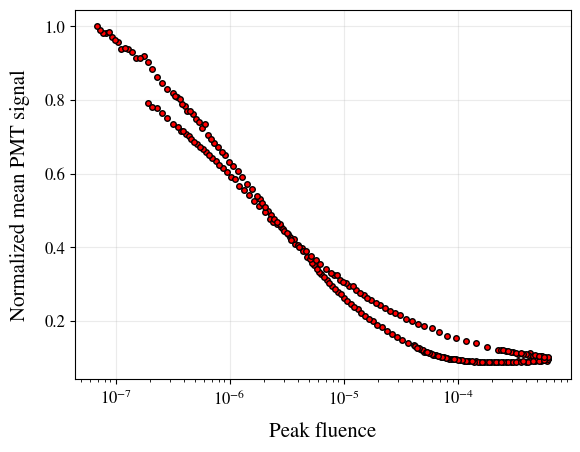

In [250]:
fig, ax = plt.subplots()

peak_fluence = 1/(m_func(positions, *new_popt_x)*m_func(positions, *new_popt_y))

ax.plot(peak_fluence, signal_pmt/max(signal_pmt), 'o', markeredgecolor='k', markerfacecolor='r', markersize=4)

ax.set_xscale('log')

ax.set_xlabel("Peak fluence", fontsize=15, labelpad=10)
ax.set_ylabel("Normalized mean PMT signal", fontsize=15, labelpad=10)
ax.grid(alpha=0.25)

fig.savefig(f"pmt-signal-fluence-{run}.png", format='png', bbox_inches="tight", dpi=300)

In [23]:
print(pd_data[:,3])
print(pos)

[447 558 274 ... 508 673 718]
75


(array([  13.,   76.,  291.,  741., 1211., 1339.,  907.,  423.,  122.,
          23.]),
 array([ 182. ,  265.1,  348.2,  431.3,  514.4,  597.5,  680.6,  763.7,
         846.8,  929.9, 1013. ]),
 <BarContainer object of 10 artists>)

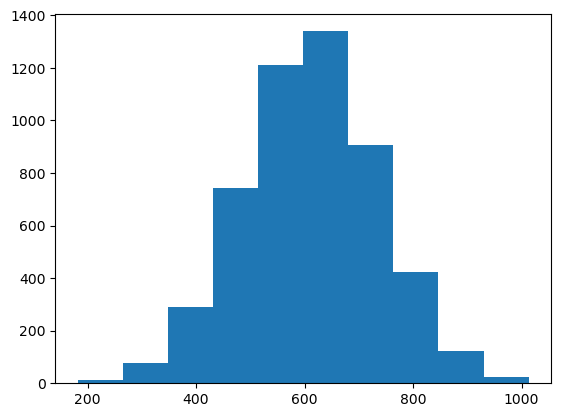

In [24]:
fig, ax = plt.subplots()

ax.hist(pd_data[:,3])